In [1]:
import logging

import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics

In [2]:
pyro.set_rng_seed(10)

In [9]:
class PMF(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self,data, train, dim,alpha):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = data.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None
        self.returned = None
        self.a = 50
        self.predictive_svi = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()
        
        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
        self.bias = self.data.mean()


    def model(self, train, mask):
        a = 50

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        with sideeffect_plate:
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
            with pyro.poutine.mask(mask=mask):
             Y = pyro.sample("target", dist.NegativeBinomial(self.a, UA@VA.T/( UA@VA.T+self.a) ), obs=train ) 
             return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
           # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
    
    def train_SVI(self,train,mask, nsteps=250, lr = 0.05, lrd = 1, verbose=True):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float(), mask)
            losses.append(elbo)
            if(verbose):
                if step % 10 == 0:
                    print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        unmasked =torch.ones((self.n,self.m), dtype=torch.bool)
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None , unmasked)
        self.predictive_svi = predictive_svi
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        self.returned = table
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
        mc_table[mc_table < self.bounds[1]] = self.bounds[0]
        mc_table[mc_table >= self.bounds[1]] = self.bounds[1]
        self.predictions = mc_table

    def predictive_score(self,test,masked):
        # total = test.shape[0]*test.shape[1]
        
        UA =  self.predictive_svi["UA"]
        VA = self.predictive_svi["VA"]
        VA = VA.mean(axis=0).reshape(self.m,self.dim)
        UA = UA.mean(axis=0).reshape(self.n,self.dim)
        print(UA.shape)
        score = dist.NegativeBinomial(self.a, UA@VA.T/( UA@VA.T+self.a)).log_prob(torch.from_numpy(test))
        mean_score = (score*masked).reshape(-1).logsumexp(-1) -np.log(test.shape[0]*test.shape[1])
        return mean_score

 
    
    def rmse(self,test):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < high] = low
        test_data[test_data >= high] = high
        sqerror = abs(test_data - self.predictions) ** 2  # squared error array
        mse = sqerror.sum()/(test_data.shape[0]*test_data.shape[1])
        print("PMF MAP training RMSE: %.5f" % np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data.astype(int).flatten(),  self.predictions.astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    
   
       

In [4]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)

nan_mask = np.isnan(data) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
print(torch.from_numpy(nan_mask) )

(1127, 5237)
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [12]:
with open('data_train.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

def predictive_score_for_diim_estimation(data_all, train, classname):
    score=[]
    for d in [1,5,10,20,50,75,100,200,250]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, d,50)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask), verbose = False)
        test.sample_predict(500)
        score.append(test.predictive_score(data_all,  torch.from_numpy(nan_mask)))
    return score

s = predictive_score_for_diim_estimation(data,data2, PMF)


(1127, 5237)
UA: (500, 1, 1127, 1)
VA: (500, 1, 5237, 1)
target: (500, 1127, 5237)
torch.Size([1127, 1])
UA: (500, 1, 1127, 5)
VA: (500, 1, 5237, 5)
target: (500, 1127, 5237)
torch.Size([1127, 5])
UA: (500, 1, 1127, 10)
VA: (500, 1, 5237, 10)
target: (500, 1127, 5237)
torch.Size([1127, 10])
UA: (500, 1, 1127, 20)
VA: (500, 1, 5237, 20)
target: (500, 1127, 5237)
torch.Size([1127, 20])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 75)
VA: (500, 1, 5237, 75)
target: (500, 1127, 5237)
torch.Size([1127, 75])
UA: (500, 1, 1127, 100)
VA: (500, 1, 5237, 100)
target: (500, 1127, 5237)
torch.Size([1127, 100])
UA: (500, 1, 1127, 200)
VA: (500, 1, 5237, 200)
target: (500, 1127, 5237)
torch.Size([1127, 200])
UA: (500, 1, 1127, 250)
VA: (500, 1, 5237, 250)
target: (500, 1127, 5237)
torch.Size([1127, 250])


In [10]:
def predictive_score_for_alpha_estimation(data_all, train, classname):
    score=[]
    for alpha in [0.1,1,5,10,50,100]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, 50,alpha)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask), verbose = False)
        test.sample_predict(500)
        score.append(test.predictive_score(data_all,  torch.from_numpy(nan_mask)))
    return score
a = predictive_score_for_alpha_estimation(data,data2, PMF)


UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])


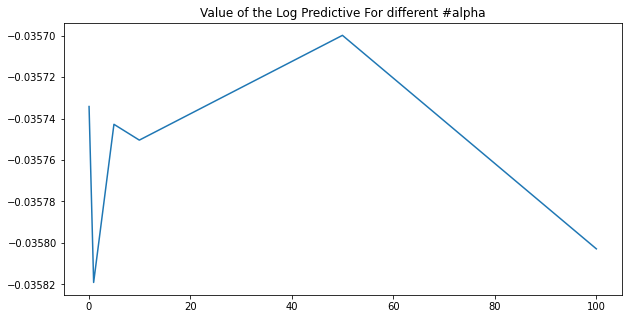

In [11]:
alpha= [0.1,1,5,10,50,100]
plt.figure(figsize=(10, 5))
plt.plot(alpha, a)
plt.title("Value of the Log Predictive For different #alpha")
plt.savefig("predictive_score_NB_alpha.png")
plt.show()
pyro.clear_param_store()

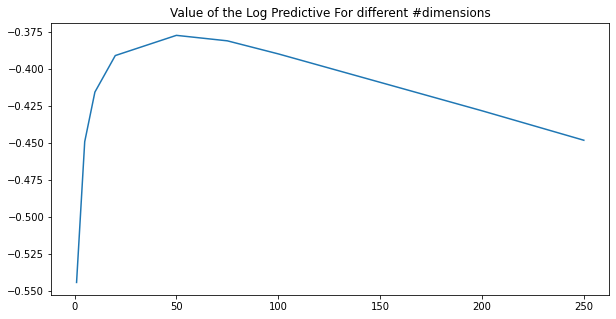

In [6]:
d = [1,5,10,20,50,75,100,200,250]
plt.figure(figsize=(10, 5))
plt.plot(d, s)
plt.title("Value of the Log Predictive For different #dimensions")
plt.savefig("predictive_score_NB.png")
plt.show()
pyro.clear_param_store()

In [8]:
test = PMF(train=data, dim=100)
test.train_SVI(data, ~torch.from_numpy(nan_mask))


Elbo loss: 9055118.078125
Elbo loss: 9098882.40625
Elbo loss: 9098319.78125
Elbo loss: 8944937.421875
Elbo loss: 8960036.609375
Elbo loss: 8975340.296875
Elbo loss: 8975446.015625
Elbo loss: 8960144.546875
Elbo loss: 8974696.4921875
Elbo loss: 8968002.8671875
Elbo loss: 8966022.4765625
Elbo loss: 8903937.1484375
Elbo loss: 8957122.9453125
Elbo loss: 8926410.2265625
Elbo loss: 8925323.78125
Elbo loss: 9011655.4296875
Elbo loss: 8939463.015625
Elbo loss: 8934858.796875
Elbo loss: 8910493.421875
Elbo loss: 8971726.765625
Elbo loss: 8934409.6484375
Elbo loss: 8939027.8984375
Elbo loss: 8913324.953125
Elbo loss: 8867438.7578125
Elbo loss: 8900528.0390625


[9055118.078125,
 9083290.515625,
 9042242.46875,
 9069657.359375,
 9041994.7109375,
 9152475.5234375,
 9091170.0546875,
 9057834.6640625,
 9054962.546875,
 9086004.734375,
 9098882.40625,
 9074073.7109375,
 9104094.953125,
 9075988.625,
 9122053.78125,
 9036397.59375,
 9031093.109375,
 9022227.2265625,
 9049068.015625,
 8996837.90625,
 9098319.78125,
 9060713.2734375,
 9057273.359375,
 9011294.296875,
 9001157.75,
 9026720.7421875,
 9007314.875,
 9022993.0859375,
 9015175.3515625,
 9013876.984375,
 8944937.421875,
 9014812.75,
 8955290.6953125,
 9037072.84375,
 8952280.265625,
 8989081.21875,
 9036661.109375,
 9033199.5546875,
 9005478.7421875,
 9010961.1328125,
 8960036.609375,
 8925865.4921875,
 8939705.34375,
 8965799.1328125,
 8971165.4140625,
 9038159.875,
 8981584.1640625,
 9000537.8046875,
 8974634.4140625,
 8936924.3984375,
 8975340.296875,
 8986144.875,
 9002850.53125,
 8986332.9375,
 8928115.234375,
 8966553.3515625,
 8958798.046875,
 9011376.640625,
 8944591.359375,
 897208

In [9]:
test.sample_predict(1000)

UA: (1000, 1, 1127, 100)
VA: (1000, 1, 5237, 100)
target: (1000, 1127, 5237)
[[[  0.   0.   0. ...   1.   4.   0.]
  [  0.   0.   0. ...   1.   0.   0.]
  [  0.   4.   0. ...   1.   9.   0.]
  ...
  [ 12.   0.   1. ... 105.  18.   1.]
  [  4.   0.   0. ...   9.   9.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[  2.   3.   0. ...   0.   1.   0.]
  [  0.   0.   0. ...   0.   2.   0.]
  [  0.   0.   0. ...   1.   5.   0.]
  ...
  [ 33.   1.   0. ...  66.   7.   1.]
  [  0.   0.   0. ...   5.  16.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[  1.   0.   0. ...   1.   2.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  1.   0.   0. ...   1.   3.   0.]
  ...
  [ 15.   0.   0. ...  48.   6.   0.]
  [  5.   0.   0. ...   4.   8.   0.]
  [  0.   0.   0. ...   0.   1.   0.]]

 ...

 [[  1.   0.   0. ...   1.   1.   1.]
  [  0.   0.   0. ...   1.   0.   0.]
  [  1.   0.   0. ...   3.   1.   0.]
  ...
  [ 24.   0.   0. ...  20.  20.   0.]
  [  2.   0.   0. ...   6.   5.   0.]
  [  0.   0. 

In [10]:
test.rmse(data)
print(test.get_predictions())
print(data)

PMF MAP training RMSE: 0.32548
AUC: 0.84278
(array([[[  0.,   0.,   0., ...,   1.,   4.,   0.],
        [  0.,   0.,   0., ...,   1.,   0.,   0.],
        [  0.,   4.,   0., ...,   1.,   9.,   0.],
        ...,
        [ 12.,   0.,   1., ..., 105.,  18.,   1.],
        [  4.,   0.,   0., ...,   9.,   9.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  2.,   3.,   0., ...,   0.,   1.,   0.],
        [  0.,   0.,   0., ...,   0.,   2.,   0.],
        [  0.,   0.,   0., ...,   1.,   5.,   0.],
        ...,
        [ 33.,   1.,   0., ...,  66.,   7.,   1.],
        [  0.,   0.,   0., ...,   5.,  16.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  1.,   0.,   0., ...,   1.,   2.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  1.,   0.,   0., ...,   1.,   3.,   0.],
        ...,
        [ 15.,   0.,   0., ...,  48.,   6.,   0.],
        [  5.,   0.,   0., ...,   4.,   8.,   0.],
        [  0.,   0.,   0., ...,   0.,   1.,  